In [1]:
import matplotlib.pyplot as plt
import equinox as eqx
import optax
import jax.numpy as jnp
import jax
import jax.random as jr
from functools import partial
from tqdm.auto import tqdm
from typing import Tuple, List, Dict, Any, Callable
import dataclasses
from models.transformer import Transformer
from datasets.parity import Parity
from jax_tqdm import scan_tqdm

In [2]:
@dataclasses.dataclass(unsafe_hash=True)
class TrainConfig:
    lrs: jax.Array
    num_seeds: int
    criterion: Callable
    model: type
    dataset: type
    model_config: Any = None
    num_steps: int = 5000
    rng_key: jax.Array = dataclasses.field(default_factory=lambda: jr.PRNGKey(0))
    batch_size: int = 32
    trainset_size: int = -1 # -1 for online dataset
    dataset_config: Any = None

    def replace(self, **kwargs):
        return dataclasses.replace(self, **kwargs)


def compute_metrics(logits, labels, loss):
    """Compute accuracy and loss from predictions"""
    preds = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(preds == labels)
    return {'accuracy': accuracy, 'loss': loss}


def init_model(config: TrainConfig, key):
    """Initialize models and optimizers for all seeds and learning rates"""
    if config.model_config is None:
        config.model_config = config.model.config()
    
    # Split keys for each seed
    keys = jr.split(key, config.num_seeds)
    
    def init_single_seed(seed_key):
        """Initialize models for all learning rates for one seed"""
        lr_keys = jr.split(seed_key, len(config.lrs))
        
        def init_single_model(model_key):
            model = config.model(config.model_config, model_key)

            optimizer = optax.adamw(1.0)  # LR will be set per-model
            opt_state = optimizer.init(model)
            # model = eqx.partition(model, eqx.is_array)
            return model, opt_state
        
        # Vmap over learning rates
        models, opt_states = jax.vmap(init_single_model)(lr_keys)
        return models, opt_states
    
    # Vmap over seeds
    models, opt_states = jax.vmap(init_single_seed)(keys)
    return models, opt_states

In [3]:
@partial(jax.jit, static_argnames=('criterion','num_seeds'))
# @eqx.filter_jit
def gradient_step_batch(models, opt_states, data, lrs, criterion, key, num_seeds):
    """Train step vmapped over seeds and learning rates - returns models, opt_states, and metrics"""
    # Split keys for each seed
    keys = jr.split(key, num_seeds)

    @partial(jax.vmap, in_axes=(0,0,0))
    def train_seed(model, key, data):
        X, y = data
        def loss_fn(model):
            y_pred = eqx.filter_vmap(model, in_axes=(0,None))(X, key)[..., -1, :]
            return criterion(y_pred, y), y_pred
        # Further split keys for each LR
        (loss, logits), grads = jax.vmap(eqx.filter_value_and_grad(loss_fn, has_aux=True))(model)
        # Compute metrics
        metrics = jax.vmap(compute_metrics, in_axes=(0,None,0))(logits, y, loss)
        return grads, metrics
    
    grads, metrics = train_seed(models, keys, data)

    # Update model
    # opt_state = optimizer.init(model)
    @partial(jax.vmap, in_axes=(0,1,1,1), out_axes=1)
    def update(lr, grads, opt_state, model):
        updates, opt_state = jax.vmap(optax.adamw(lr).update)(
            grads, opt_state, model
        )
        model = jax.vmap(eqx.apply_updates)(model, updates)
        return model, opt_state
    
    models, opt_states = update(lrs, grads, opt_states, models)
    return models, opt_states, metrics


# @partial(jax.jit, static_argnames=('criterion',))
@partial(jax.jit, static_argnames=('criterion',))
@partial(jax.vmap, in_axes=(0,None, None))
@partial(jax.vmap, in_axes=(0,None, None))
def eval_step_single(model, data, criterion):
    """Eval step for a single model - returns metrics"""
    X, y = data
    logits = jax.vmap(model, in_axes=(0,None))(X, None)[..., -1, :]
    loss = criterion(logits, y)
    metrics = compute_metrics(logits, y, loss)
    return metrics

In [8]:
# Should be fine to change things in this block


def train(train_config: TrainConfig):
    num_steps = train_config.num_steps
    rng_key = train_config.rng_key
    rng_key, test_key = jr.split(rng_key)
    dataset = train_config.dataset(train_config.dataset_config)
    test_data = dataset.create_batch(test_key, 256)

    if train_config.trainset_size == -1:
        @jax.jit
        def get_data(key):
            return dataset.create_batches(key, train_config.batch_size, train_config.num_seeds)
    else:
        rng_key, data_key = jr.split(rng_key)
        offline_data = dataset.create_batches(data_key, train_config.trainset_size, train_config.num_seeds)
        @jax.vmap
        def _get_data(key, _offline_dataset):
            inds = jax.random.randint(key, (train_config.batch_size), 0, 5000,)
            return _offline_dataset[0][inds],_offline_dataset[1][inds]
        @jax.jit
        def get_data(key):
            return _get_data(jr.split(key, train_config.num_seeds), offline_data)
    
    rng_key, init_key = jr.split(rng_key)
    models, optimizer_states = init_model(train_config, init_key)

    metrics_history = {
        'train_loss': [],
        'train_accuracy': [],
        'test_loss': [],
        'test_accuracy': [],
    }
    pbar = tqdm(range(num_steps))
    for step in pbar:
        # Create training batches
        rng_key, batch_key, train_key = jr.split(rng_key, 3)
        
        data = get_data(batch_key)
        # Training step - returns models, opt_states, and train_metrics
        models, optimizer_states, train_metrics = gradient_step_batch(
            models, optimizer_states, data, train_config.lrs, train_config.criterion, train_key, train_config.num_seeds
        )
        
        # Extract train metrics (shape: [num_seeds, num_lrs])
        train_acc = jnp.array(train_metrics['accuracy'])
        train_loss = jnp.array(train_metrics['loss'])
        
        # Record best metrics: mean across seeds, then min loss / max accuracy across LRs
        metrics_history['train_loss'].append(train_loss.mean(axis=0).min())
        metrics_history['train_accuracy'].append(train_acc.mean(axis=0).max())
        # test_metrics = eval_step_single(models, test_data, train_config.criterion)
        
        if step % 50 == 0:
            # Eval step - returns test_metrics
            test_metrics = eval_step_single(models, test_data, train_config.criterion)
            # Extract test metrics (shape: [num_seeds, num_lrs])
            test_acc = jnp.array(test_metrics['accuracy'])
            test_loss = jnp.array(test_metrics['loss'])
            # Record best metrics
            metrics_history['test_loss'].append(test_loss.mean(axis=0).min())
            metrics_history['test_accuracy'].append(test_acc.mean(axis=0).max())
        
        if step % 500 == 0:
            # print(f"Step {step}: Train acc={metrics_history['train_accuracy'][-1]:.4f}, "
            #         f"Test acc={metrics_history['test_accuracy'][-1]:.4f}")
            pbar.set_postfix(train_acc=metrics_history['train_accuracy'][-1])#, test_acc=metrics_history['test_accuracy'][-1])
    return metrics_history

In [5]:
# Feel free to change the parameters in this block

dataset_config = Parity.config(d=20, k=6)

model_config = Transformer.config(
    vocab_size=2,
    max_len=dataset_config.d,
    embd_dim=256,
    mlp_dim=1024,
    qkv_dim=512,
    num_heads=8,
    num_layers=2,
    dtype=jnp.float32
)

config = TrainConfig(
    lrs=jnp.geomspace(1e-4, 1e-1, 5),
    num_seeds=6,
    criterion=lambda y_pred, y: optax.softmax_cross_entropy_with_integer_labels(y_pred, y).mean(),
    model=Transformer,
    trainset_size = -1,
    dataset=Parity,
    dataset_config=dataset_config,
    model_config=model_config,
    num_steps = 5000,
)


In [9]:
config.replace(trainset_size=-1)
online_metrics_history = train(config)
offline_config = config.replace(trainset_size=5000)
offline_metrics_history = train(offline_config)


  0%|          | 0/5000 [00:00<?, ?it/s]

ValueError: vmap got inconsistent sizes for array axes to be mapped:
  * most axes (47 of them) had size 5, e.g. axis 0 of argument model.embeddings.weight of type float32[5,6,2,256];
  * some axes (3 of them) had size 6, e.g. axis 0 of argument key of type uint32[6,2]

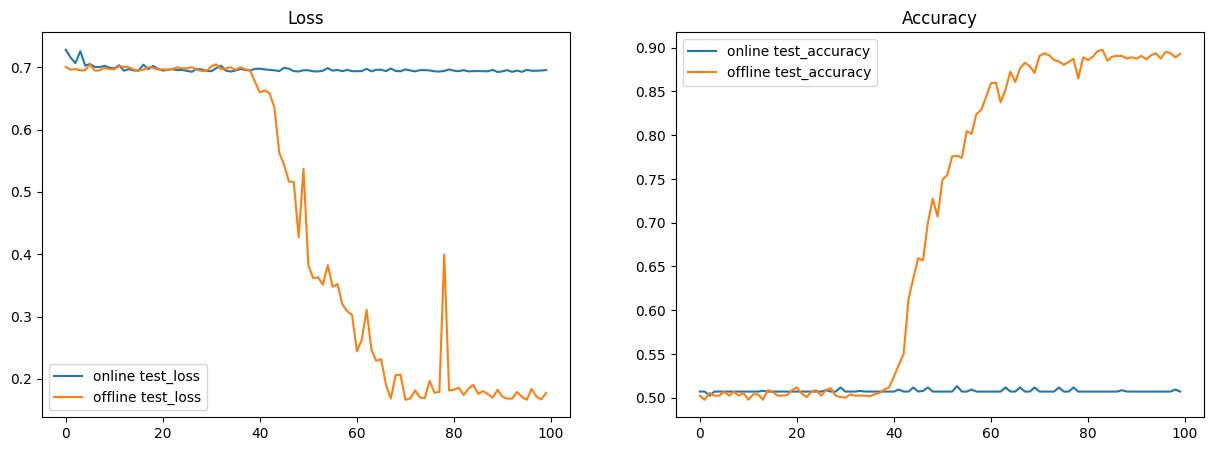

In [30]:
metrics = {"online": online_metrics_history, "offline": offline_metrics_history, }
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for metric in metrics:
    for dataset in ('test',):
        ax1.plot(metrics[metric][f'{dataset}_loss'], label=f'{metric} {dataset}_loss')
        ax2.plot(metrics[metric][f'{dataset}_accuracy'], label=f'{metric} {dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()

In [7]:
# more complicated, not better


@partial(jax.jit, static_argnames=('criterion','num_seeds'))
def gradient_steps_batch(models, opt_states, datem, lrs, criterion, key, num_seeds):
    model_dynamic, model_static = eqx.partition(models, eqx.is_array)
    def gradient_step_scan(carry, data):
        model_dynamic, opt_states = carry
        models = eqx.combine(model_dynamic, model_static)
        models, _, metrics = gradient_step_batch(models, opt_states, data, lrs, criterion, key, num_seeds)
        model_dynamic, _ = eqx.partition(models, eqx.is_array)
        return (model_dynamic, opt_states), metrics
    # keys = jr.split(key, num_steps)
    # print(gradient_step_scan((model_dynamic, opt_states), (datem[0][0], datem[1][0])))
    return jax.lax.scan(gradient_step_scan, (model_dynamic, opt_states), datem)

def train(train_config: TrainConfig):
    num_steps = train_config.num_steps
    rng_key = train_config.rng_key
    rng_key, test_key = jr.split(rng_key)
    dataset = train_config.dataset(train_config.dataset_config)
    test_data = dataset.create_batch(test_key, 256)

    if train_config.trainset_size == -1:
        @jax.jit
        def get_data(key):
            return dataset.create_batches(key, train_config.batch_size, train_config.num_seeds)
    else:
        rng_key, data_key = jr.split(rng_key)
        offline_data = dataset.create_batches(data_key, train_config.trainset_size, train_config.num_seeds)
        @jax.vmap
        def _get_data(key, _offline_dataset):
            inds = jax.random.randint(key, (train_config.batch_size), 0, 5000,)
            return _offline_dataset[0][inds],_offline_dataset[1][inds]
        @jax.jit
        @jax.vmap
        def get_data(key):
            return _get_data(jr.split(key, train_config.num_seeds), offline_data)
    
    rng_key, init_key = jr.split(rng_key)
    models, optimizer_states = init_model(train_config, init_key)

    metrics_history = {
        'train_loss': [],
        'train_accuracy': [],
        'test_loss': [],
        'test_accuracy': [],
    }
    pbar = tqdm(range(num_steps//50))
    for step in pbar:
        # Create training batches
        rng_key, batch_key, train_key = jr.split(rng_key, 3)
        batch_key = jr.split(batch_key, 50)
        datem = get_data(batch_key)
        # Training step - returns models, opt_states, and train_metrics
        (models, optimizer_states), train_metrics = train_steps_batch(
            models, optimizer_states, datem, train_config.lrs, train_config.criterion, train_key, train_config.num_seeds
        )
        
        # Extract train metrics (shape: [num_seeds, num_lrs])
        train_acc = jnp.array(train_metrics['accuracy'])
        train_loss = jnp.array(train_metrics['loss'])
        # Record best metrics: mean across seeds, then min loss / max accuracy across LRs
        metrics_history['train_loss'].extend(train_loss.mean(axis=-2).min(axis=-1))
        metrics_history['train_accuracy'].extend(train_acc.mean(axis=-2).max(axis=-1))
        
        if step % 50 == 0:
            # Eval step - returns test_metrics
            test_metrics = eval_step_batch(models, test_data, train_config.criterion)
            
            # Extract test metrics (shape: [num_seeds, num_lrs])
            test_acc = jnp.array(test_metrics['accuracy'])
            test_loss = jnp.array(test_metrics['loss'])
            
            # Record best metrics
            metrics_history['test_loss'].append(test_loss.mean(axis=0).min())
            metrics_history['test_accuracy'].append(test_acc.mean(axis=0).max())
        
        if step % 10 == 0:
            # print(f"Step {step}: Train acc={metrics_history['train_accuracy'][-1]:.4f}, "
            #         f"Test acc={metrics_history['test_accuracy'][-1]:.4f}")
            pbar.set_postfix(train_acc=metrics_history['train_accuracy'][-1], test_acc=metrics_history['test_accuracy'][-1])
    return metrics_history

In [56]:
# more complicated, not better


def train(train_config: TrainConfig):
    num_steps = train_config.num_steps
    rng_key = train_config.rng_key
    rng_key, test_key = jr.split(rng_key)
    dataset = train_config.dataset(train_config.dataset_config)
    test_data = dataset.create_batch(test_key, 256)
    if train_config.trainset_size == -1:
        @jax.jit
        @jax.vmap
        def get_data(key):
            return dataset.create_batches(key, train_config.batch_size, train_config.num_seeds)
    else:
        rng_key, data_key = jr.split(rng_key)
        offline_data = dataset.create_batches(data_key, train_config.trainset_size, train_config.num_seeds)
        @jax.vmap
        def _get_data(key, _offline_dataset):
            inds = jax.random.randint(key, (train_config.batch_size), 0, 5000,)
            return _offline_dataset[0][inds],_offline_dataset[1][inds]
        @jax.jit
        def get_data(key):
            return _get_data(jr.split(key, train_config.num_seeds), offline_data)
    
        
    rng_key, init_key = jr.split(rng_key)
    models, optimizer_states = init_model(train_config, init_key)

    
    model_dynamic, model_static = eqx.partition(models, eqx.is_array)
    opt_dynamic, opt_static = eqx.partition(optimizer_states, eqx.is_array)
    @jax.jit
    @scan_tqdm(train_config.num_steps, print_rate=5)
    def train_step(carry, x):
        _, key = x
        model_dynamic, opt_dynamic = carry
        opt_state = eqx.combine(opt_dynamic, opt_static)
        models = eqx.combine(model_dynamic, model_static)
        data_key, train_key = jr.split(key)
        data = get_data(data_key)
        # train_key = jr.split(train_key, train_config.num_seeds)

        # keys = jr.split(key, train_config.num_seeds)
        models, opt_dynamic, train_metrics = gradient_step_batch(
            models, opt_state, data, train_config.lrs, train_config.criterion, train_key, train_config.num_seeds
        )
        test_metrics = eval_step_batch(models, test_data, train_config.criterion)
        opt_dynamic, _ = eqx.partition(opt_state, eqx.is_array)
        
        model_dynamic, _ = eqx.partition(models, eqx.is_array)
        return (model_dynamic, opt_dynamic), (train_metrics, test_metrics)
    keys = jr.split(rng_key, num_steps)
    (models, optimizer_states), (train_metrics, test_metrics) = jax.lax.scan(train_step, (model_dynamic, optimizer_states), (jnp.arange(train_config.num_steps), keys))
    metrics_history = {
        'train_loss': [],
        'train_accuracy': [],
        'test_loss': [],
        'test_accuracy': [],
    }
    
    return (train_metrics, test_metrics)
